Data 245 : Group 7 Team Project :: A Comprehensive Approach to Content Recommendation and Revenue Forecasting with ML

# New Section

INITIAL PROEJCT SETUP - Give access to a common shared drive for all team members to collaborate

In [ ]:
# Mount to Google Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Navigate to the necessary folder

%cd '/content/drive/Shareddrives/Data245'


/content/drive/Shareddrives/Data245


In [ ]:
# List the contents of the directory

!ls

dfmerged.csv  newcredits.csv  newmovies.csv  tmdb_5000_credits.csv  tmdb_5000_movies.csv


START WORKING ON THE PROJECT SETUP

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json # parse the features stored as json values

Read the csv files

In [ ]:
# Read the two files

credits = pd.read_csv("tmdb_5000_credits.csv")
movies = pd.read_csv("tmdb_5000_movies.csv")

In [ ]:
# List the rows and columns

movies.shape

(4803, 20)

In [ ]:
# List the rows and columns

credits.shape

(4803, 4)

In [ ]:
# List the top three records

movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [ ]:
# Select only the features required
movies = movies[['id', 'title', 'overview', 'genres', 'keywords']]

# List the first record
movies.head(1)

,id,title,overview,genres,keywords
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":..."


In [ ]:
# Create a copy of the DataFrame using the copy() method, for data cleansing

movies_copy = movies.copy()

In [ ]:
# Drop null values

movies_copy.dropna(inplace=True)

In [ ]:
# Show the first record of genres, it is a json string with id and name

movies_copy.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [ ]:
def convert(obj):
    List = []
    for i in ast.literal_eval(obj):
        List.append(i['name'])
    return List

In [ ]:
# Import Abstract Syntax Tree
# Only evaluates literals and does not execute arbitrary code
# Used to parse out the json string
import ast
# Parse out the json by calling function

movies_copy['genres'] = movies_copy['genres'].apply(convert)
movies_copy['keywords'] = movies_copy['keywords'].apply(convert)

In [ ]:
# Create the 'overview' feature as comma separated list

movies_copy['overview'] = movies_copy['overview'].apply(lambda x:x.split())

In [ ]:
# Removes any spaces with in the 'genres' and 'keywords' features

movies_copy['genres'] = movies_copy['genres'].apply(lambda x:[i.replace(" ","") for i in x])
movies_copy['keywords'] = movies_copy['keywords'].apply(lambda x:[i.replace(" ","") for i in x])

In [ ]:
# Concatenate and create a new feature called 'tags'

movies_copy['tags'] = movies_copy['overview'] + movies_copy['genres'] + movies_copy['keywords']

In [ ]:
# Create a new dataframe to store the features
new_df = movies_copy[['id', 'title', 'tags']].copy()

# Create a string containing all the tags separated by space
new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))

In [ ]:
# using the Hugging Face transformers library along with a
# pre-trained BERT model to recommend movies based on their titles, overview, genres, keywords

from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import time

# Combine 'title' and 'tags' columns
combined_text = new_df['title'].head(100) + ' ' + new_df['tags'].head(100)
#.head(100)

# Record the start time
start_time = time.time()

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize movie titles and tags
movie_tokens = tokenizer(combined_text.tolist(), return_tensors='pt', padding=True, truncation=True)
user_tokens = tokenizer("riding in cars", return_tensors='pt')

# Get BERT embeddings for movies and user input

# Disables gradient calculation for efficiency.
with torch.no_grad():
    # Obtains BERT embeddings for the movie titles and tags by taking the mean along the sequence length dimension
    movie_embeddings = model(**movie_tokens).last_hidden_state.mean(dim=1)
    user_embedding = model(**user_tokens).last_hidden_state.mean(dim=1)

# Calculates the cosine similarity between the user input embedding and each movie embedding
similarities = cosine_similarity(user_embedding, movie_embeddings).flatten()

#  Sorts the movies based on their cosine similarity to the user input in descending order
ranked_movies = sorted(enumerate(similarities), key=lambda x: x[1], reverse=True)
# Display min and max values
min_similarity = min(ranked_movies, key=lambda x: x[1])
max_similarity = max(ranked_movies, key=lambda x: x[1])

print(f"Minimum Similarity: {min_similarity[1]:.4f}")
print(f"Maximum Similarity: {max_similarity[1]:.4f}")

# Extract the top 10 movies
top_10_indices = [movie_index for movie_index, similarity in ranked_movies[:10]]

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time} seconds")

#  Print recommended movies
print("Recommended Movies:")
for i, movie_index in enumerate(top_10_indices):
    similarity_score = ranked_movies[i][1]
    print(f"Movie {i + 1}: Similarity = {similarity_score:.4f}")
    print(f"   Title: {new_df['title'][movie_index]}")
    print(f"   Tags: {new_df['tags'][movie_index]}")
    print("-" * 50)

NameError: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the TMDB 5000 Movie Dataset
movies_df = pd.read_csv('tmdb_5000_movies.csv')

# Example: Concatenate relevant text features (title and genres)
movies_df['combined_features'] = movies_df['title'] + ' ' + movies_df['genres']

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movies_df['combined_features'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations based on cosine similarity
def get_recommendations(movie_title):
    movie_index = movies_df.index[movies_df['title'] == movie_title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:20]
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]

# Record the start time
start_time = time.time()

# Example: Get recommendations for a movie
movie_title = 'Aliens'
recommendations = get_recommendations(movie_title)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time} seconds")

print(f"Recommendations for {movie_title}:\n{recommendations}")


Recommendations for Aliens:
1002                        The One
1213    Aliens vs Predator: Requiem
4284                       C.H.U.D.
116                     I Am Legend
3749                      They Live
45                      World War Z
3158                          Alien
4693                             H.
542                        Carriers
2084                       eXistenZ
1086            Aliens in the Attic
768                          Priest
2157                    Daybreakers
2425                           They
3586             As Above, So Below
4042                         U.F.O.
1271                       Pandorum
1617                              9
1192                          Spawn
Name: title, dtype: object


**Columns description:**<br><br>

**Credits**:<br><br>
movies_id - unique movie identifier<br>
title - Title of the movie<br>
cast - star cast of the movie stored as json string<br>
crew - crew involved during the making of the movie<br>

<br><br>
**Movies**:<br><br>
budget - total budget of the movie in USD<br>
genres - list of genres for the movie stored as json string
homepage - website address of the movie<br>
id - unique movie id<br>
keywords - key words to describe the movie stored as json string<br>
original_language - the original language the movie is made in<br>
original_title - original title for the movie<br>
overview - brief over view of the movie<br>
popularity - metric used to measure the popularity of movie<br>
production_companies - production company/companies of the movie stored as json string<br>
production_countries - production countries of the movie stored as json string<br>
release_date - the date movie was released stored in yyyy-mm-dd format<br>
revenue - revenue generated by the movie<br>
runtime - total run time of movie in minutes<br>
spoken_language - the different languages spoken in movie
status - status of movie<br>
tagline - a catchphrase describing the movie
title - title of the movie<br>
vote_average - the average user rating of the movie<br>
vote_count - number of voters of the movie<br>

In [ ]:
# List the top three records

credits.head(3)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [ ]:
# The genres, keywords, production_companies, production_countries, spoken languages in the credits dataframe are
# stored as json values, id and name. Parse these values using json.loads and store only the name field
# as comma separated values list

movies['genres'] = movies['genres'].apply(lambda x:[genre['name'] for genre in json.loads(x)])
movies['keywords'] = movies['keywords'].apply(lambda x:[keywords['name'] for keywords in json.loads(x)])
movies['production_companies'] = movies['production_companies'].apply(lambda x:[production_companies['name'] for production_companies in json.loads(x)])
movies['production_countries'] = movies['production_countries'].apply(lambda x:[production_countries['name'] for production_countries in json.loads(x)])
movies['spoken_languages'] = movies['spoken_languages'].apply(lambda x:[spoken_languages['name'] for spoken_languages in json.loads(x)])

credits['cast'] = credits['cast'].apply(lambda x:[cast['name'] for cast in json.loads(x)])
credits['crew'] = credits['crew'].apply(lambda x:[crew['name'] for crew in json.loads(x)])

In [ ]:
credits.head(3)

,movie_id,title,cast,crew
0,19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B..."
1,285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe..."
2,206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John..."


In [ ]:
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,Spectre,6.3,4466


In [ ]:
# Save the DataFrames to a new csv, if need at a later time

movies.to_csv('newmovies.csv')
credits.to_csv('newcredits.csv')

PermissionError: ignored

**DATA UNDERSTANDING & DATA PREPARATION**

In [ ]:
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [ ]:
credits.describe()

,movie_id
count,4803.000000
mean,57165.484281
std,88694.614033
min,5.000000
25%,9014.500000
50%,14629.000000
75%,58610.500000
max,459488.000000


In [ ]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


Using the info method we can see that credits dataframe does not have any null values.<br><br>

The movies dataframe feature has "homepage" with 1712 values. We can remove the homepage feature since more than 65% of the values are missing.
The "tagline" feature has 3959 values.

In [ ]:
# We will focus more on the credits data frame

# Check for null values

# Cols with null values
credits_nullcols = movies.columns[movies.isnull().any()]

# Calculate the % of missing values
missing_percent = (movies[credits_nullcols].isnull().sum() / len(credits)) * 100

# create a df with missing info
missing_info = pd.DataFrame({'Column': credits_nullcols, 'Missing Percentage (%)': missing_percent})

print(missing_info)

                    Column  Missing Percentage (%)
homepage          homepage               64.355611
overview          overview                0.062461
release_date  release_date                0.020820
runtime            runtime                0.041641
tagline            tagline               17.572351


In [ ]:
# Check for duplicate counts for the various fields

# Specify the features to check for duplicates, using only the "title"
# there were 3 duplicates, but with the release_date there are no duplicate records

subset_col_duplicates = ['title', 'release_date']

# Calculate duplicates based on specified subset
duplicates = movies.duplicated(subset=subset_col_duplicates)

# Sum duplicated rows for each feature
duplicate_rows = movies[duplicates]

# Print the count of duplicated rows
print("Number of duplicated rows :\n", duplicate_rows['title'])

Number of duplicated rows :
 Series([], Name: title, dtype: object)


There are only 3 records which are duplicated if we only use the "title" Using "release_date", there are no duplicates.

In [ ]:
# print all the unique values in each feature

#for i in movies.columns:
#    print(i, len(movies[i].unique()))

In [ ]:
# Bit more in depth look at the status field

status_counts = movies['status'].value_counts()
print('Counts of the various status values:\n', status_counts)

Counts of the various status values:
 Released           4795
Rumored               5
Post Production       3
Name: status, dtype: int64


** Visualizing the distribution of all the numerical variables.**

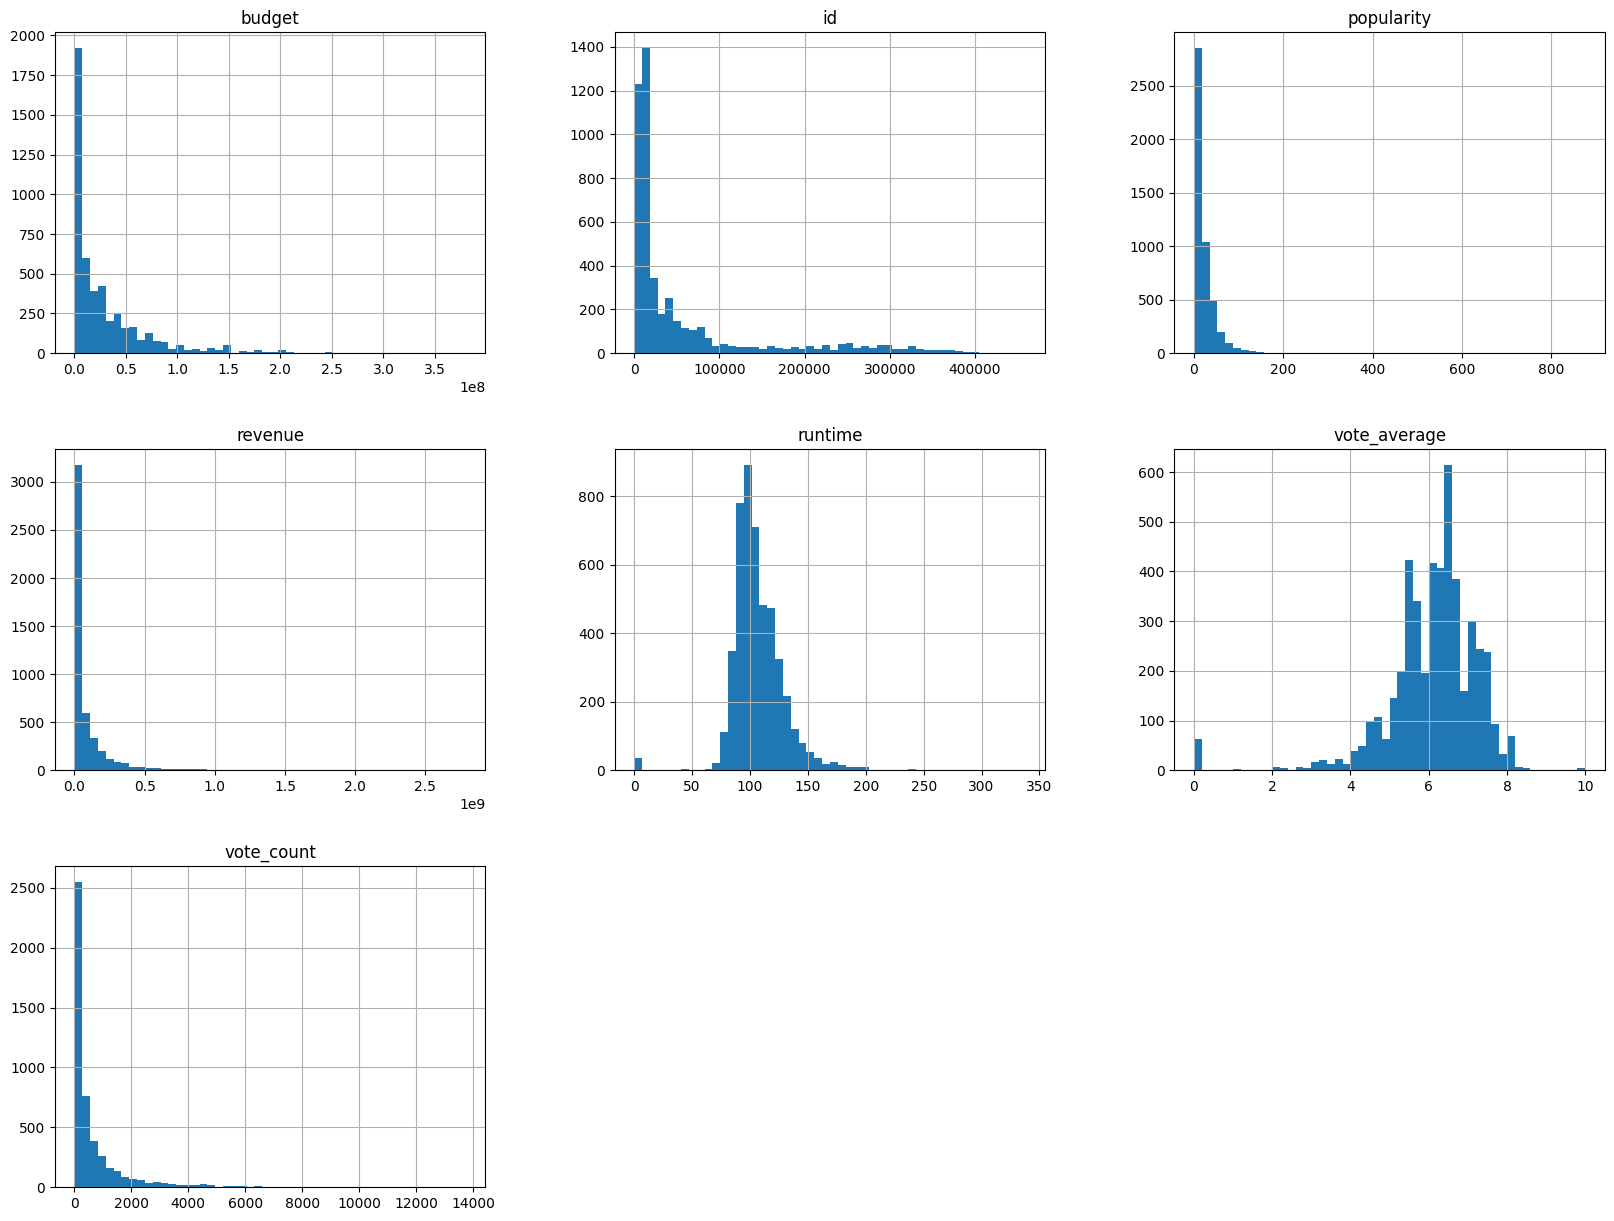

In [ ]:
movies.hist(bins=50, figsize=(20,15))
plt.show()

# what can we infer?????

Measures of Central Tendency - Mean, Median, Mode

In [ ]:
# Mean
mean_values = movies.mean(axis=0, numeric_only=True)

# format values without scientific notion
for column, mean in mean_values.items():
  print(f"{column}: {mean:.2f}")

budget: 29045039.88
id: 57165.48
popularity: 21.49
revenue: 82260638.65
runtime: 106.88
vote_average: 6.09
vote_count: 690.22


In [ ]:
# Median
median_values = movies.median(axis=0, numeric_only=True)

# format values without scientific notation
for column, median in median_values.items():
  print(f"{column}: {median:.2f}")

budget: 15000000.00
id: 14629.00
popularity: 12.92
revenue: 19170001.00
runtime: 103.00
vote_average: 6.20
vote_count: 235.00


# Measure of variablity

In [ ]:
# Standard deviation - measures the amount of variation or dispersion of data

std_values = movies.std(numeric_only=True)
# format values without scientific notation
for column, std in std_values.items():
  print(f"{column}: {std:.2f}")

budget: 40722391.26
id: 88694.61
popularity: 31.82
revenue: 162857100.94
runtime: 22.61
vote_average: 1.19
vote_count: 1234.59


In [ ]:
# variance - measure of how far the number is from the mean

var_values = movies.var(numeric_only=True)
# format values without scientific notation
for column, var in var_values.items():
  print(f"{column}: {var:.2f}")

budget: 1658313149814453.50
id: 7866734558.52
popularity: 1012.30
revenue: 26522435327503056.00
runtime: 511.30
vote_average: 1.43
vote_count: 1524202.32


In [ ]:
# Range, which requires the min and max values of the dataset
# We will be able to easily spot outliers using Range


# calculate minimum values of numeric features

min_cols = movies.select_dtypes(include=[int, float]).min()
min_cols

budget          0.0
id              5.0
popularity      0.0
revenue         0.0
runtime         0.0
vote_average    0.0
vote_count      0.0
dtype: float64

In [ ]:
# maximum values of numeric features
max_cols = movies.select_dtypes(include=[int, float]).max()
for column, maxval in max_cols.items():
    print(f"{column}: {maxval:.2f}")

budget: 380000000.00
id: 459488.00
popularity: 875.58
revenue: 2787965087.00
runtime: 338.00
vote_average: 10.00
vote_count: 13752.00


In [ ]:
range_cols = max_cols - min_cols
range_cols
# format values without scientific notation
for column, range in range_cols.items():
  print(f"{column}: {range:.2f}")

budget: 380000000.00
id: 459483.00
popularity: 875.58
revenue: 2787965087.00
runtime: 338.00
vote_average: 10.00
vote_count: 13752.00


## Checking for outliers using boxplot

In [ ]:
# Define the features to check for outliers
num_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_count']

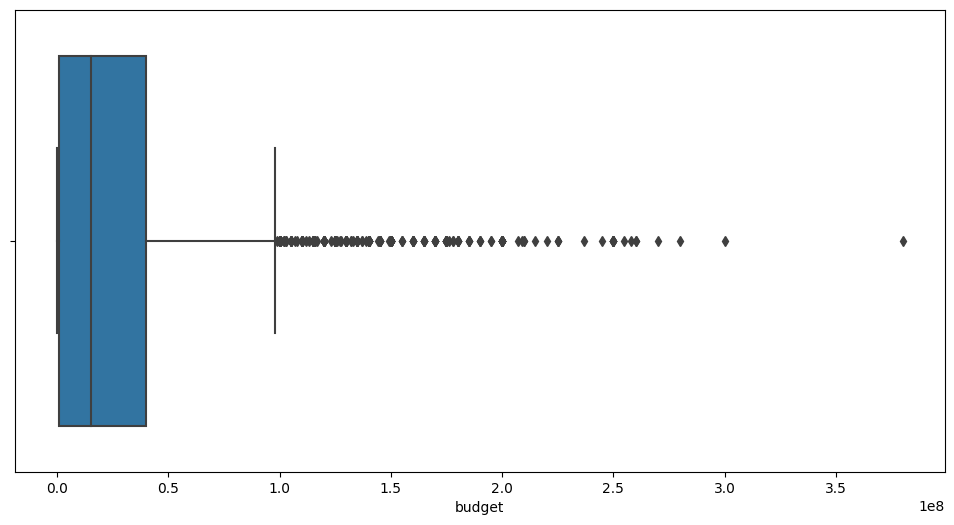

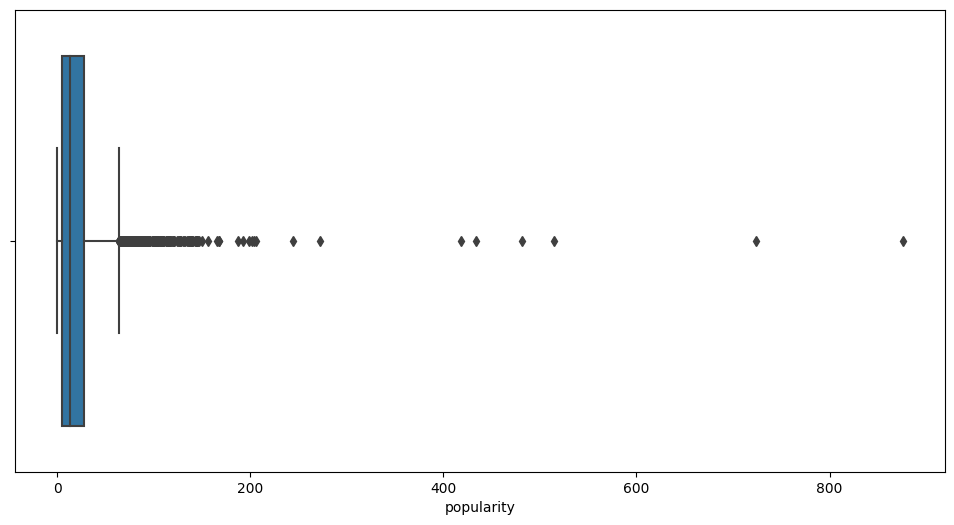

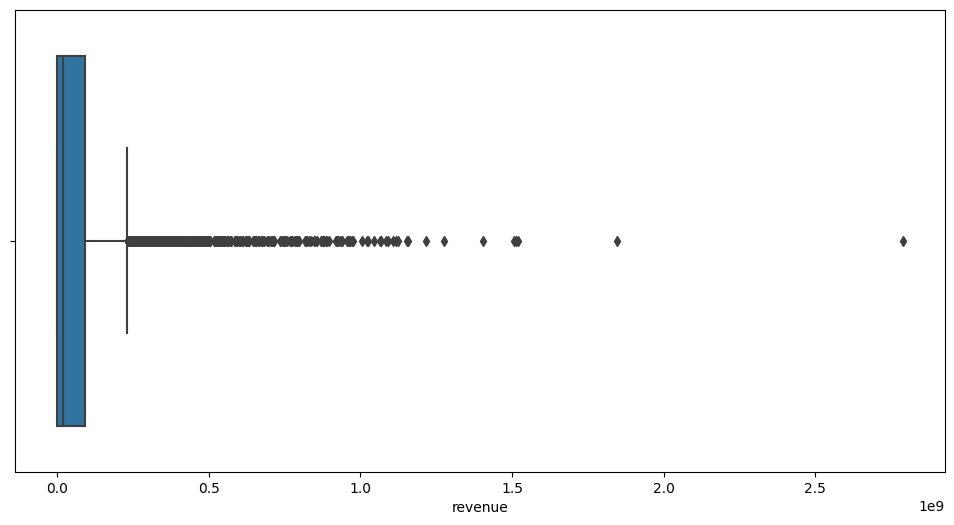

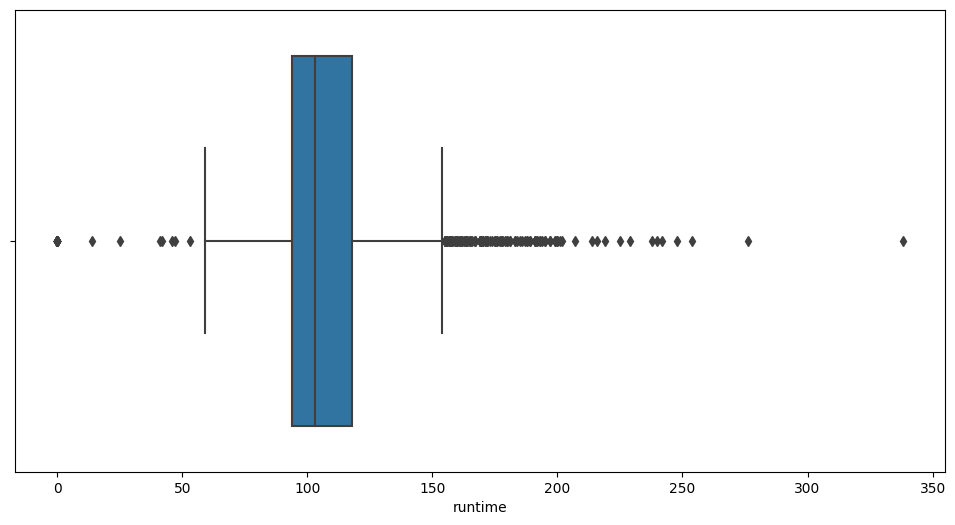

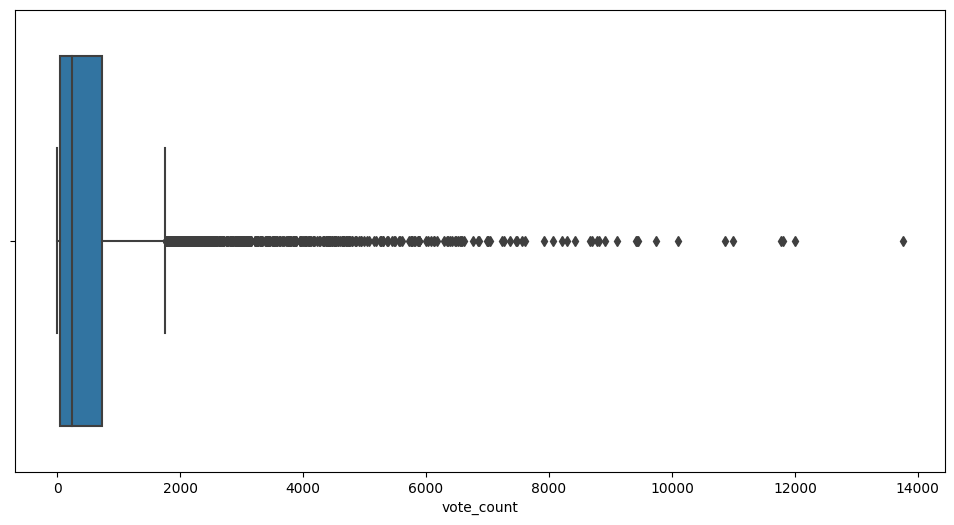

In [ ]:
for i in num_features:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 6)
    sns.boxplot(x=i,data=movies,ax=ax)

In [ ]:
#Checking correlation between columns in dataset
#Correlation measures the relationship between two variables

correlation=movies.corr()
correlation

<ipython-input-47-27b016c8dfa6>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation=movies.corr()


,budget,id,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,-0.089377,0.505414,0.730823,0.269851,0.093146,0.593180
id,-0.089377,1.000000,0.031202,-0.050425,-0.153536,-0.270595,-0.004128
popularity,0.505414,0.031202,1.000000,0.644724,0.225502,0.273952,0.778130
revenue,0.730823,-0.050425,0.644724,1.000000,0.251093,0.197150,0.781487
runtime,0.269851,-0.153536,0.225502,0.251093,1.000000,0.375046,0.271944
vote_average,0.093146,-0.270595,0.273952,0.197150,0.375046,1.000000,0.312997
vote_count,0.593180,-0.004128,0.778130,0.781487,0.271944,0.312997,1.000000


Text(0.5, 1.0, 'Correlation matrix for numeric values in the Credits Dataset')

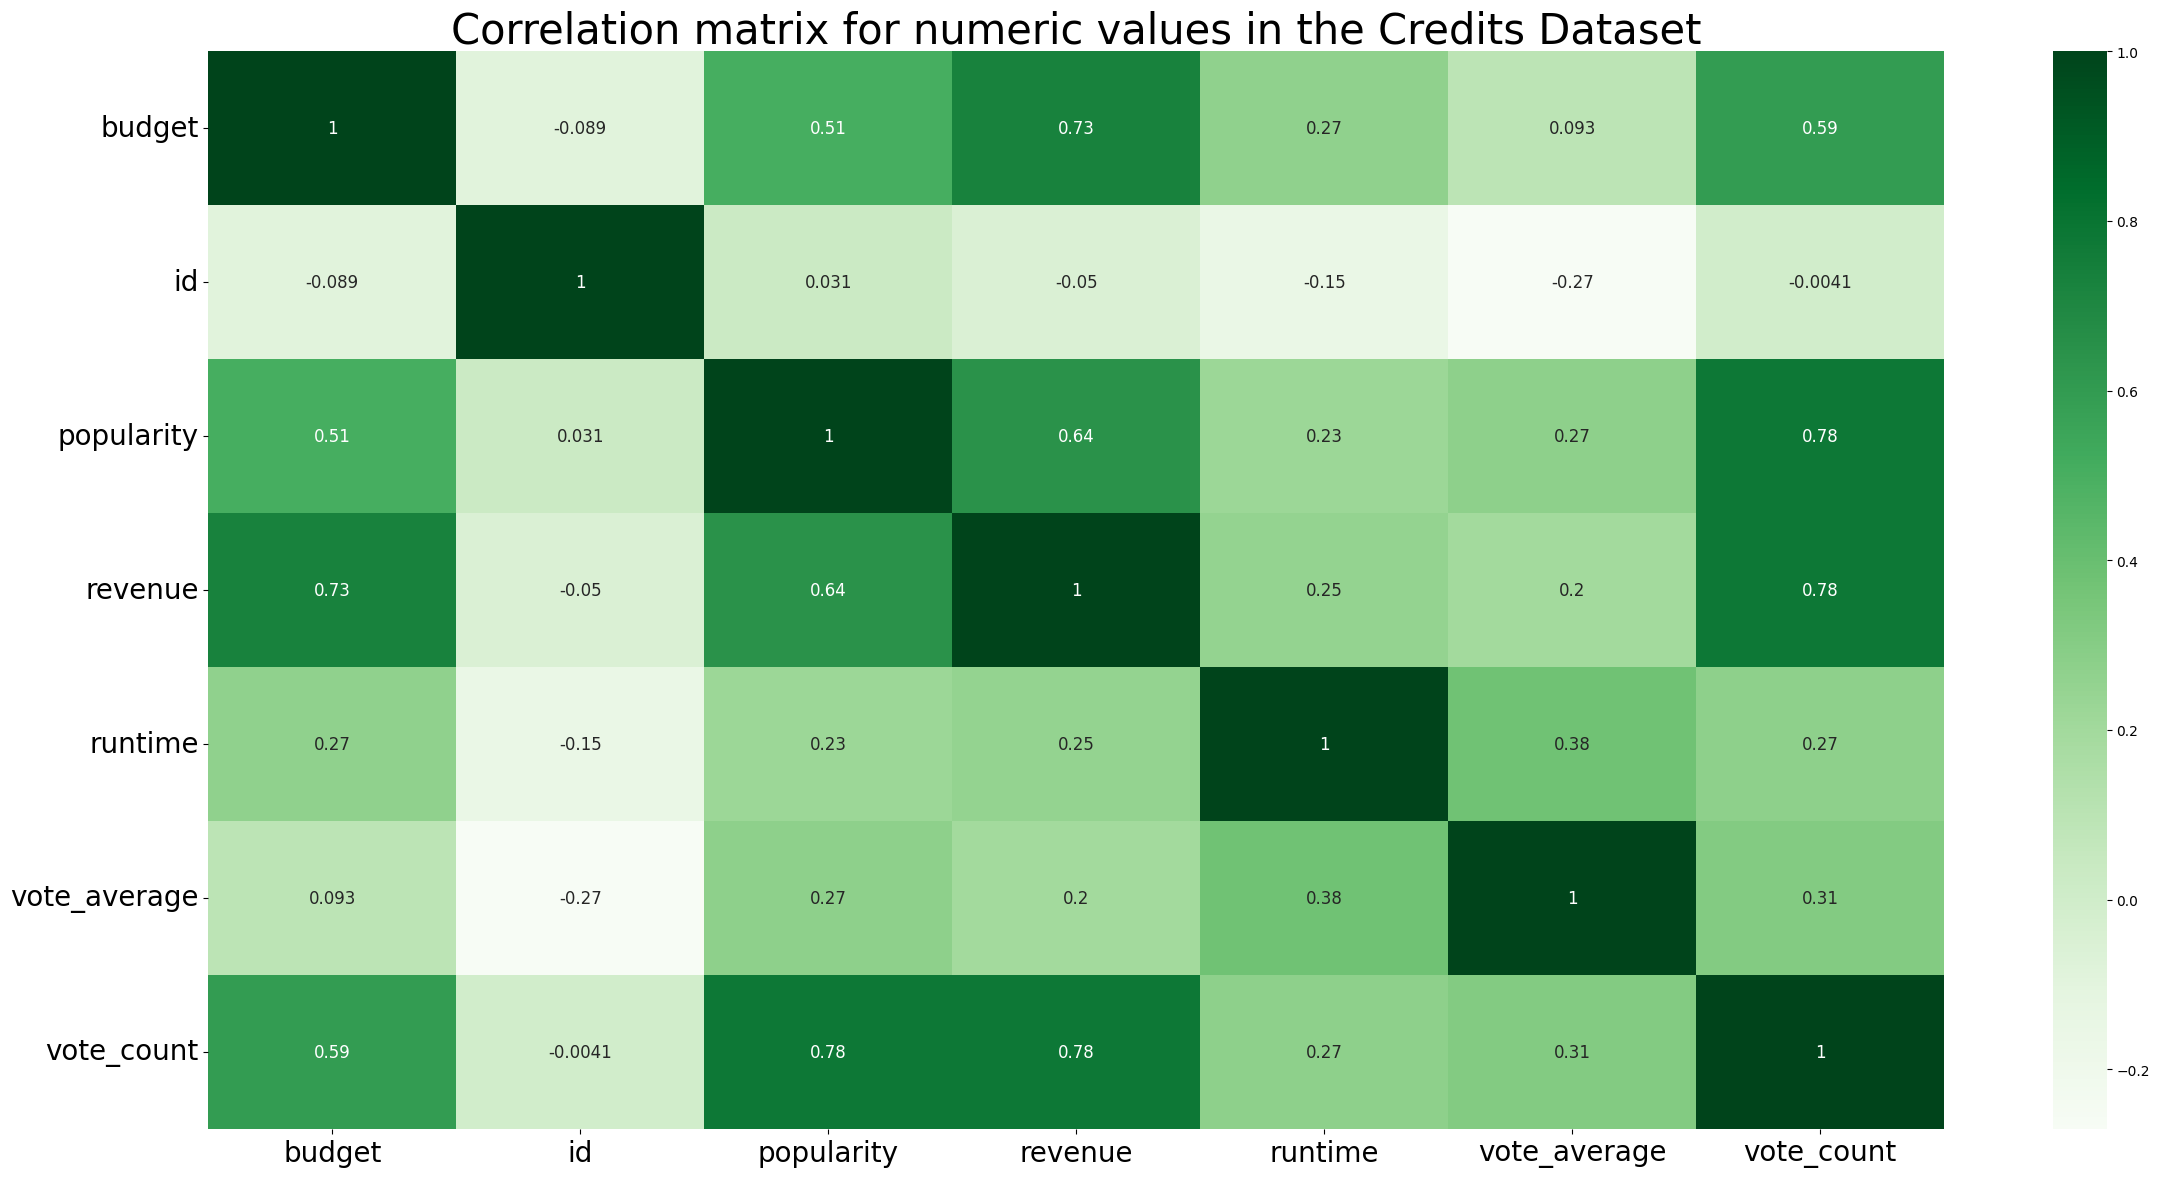

In [ ]:
plt.figure(figsize=(28,14))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.heatmap(correlation, cmap="Greens", annot=True, annot_kws={'size':12})
plt.title('Correlation matrix for numeric values in the Credits Dataset', fontsize=30)

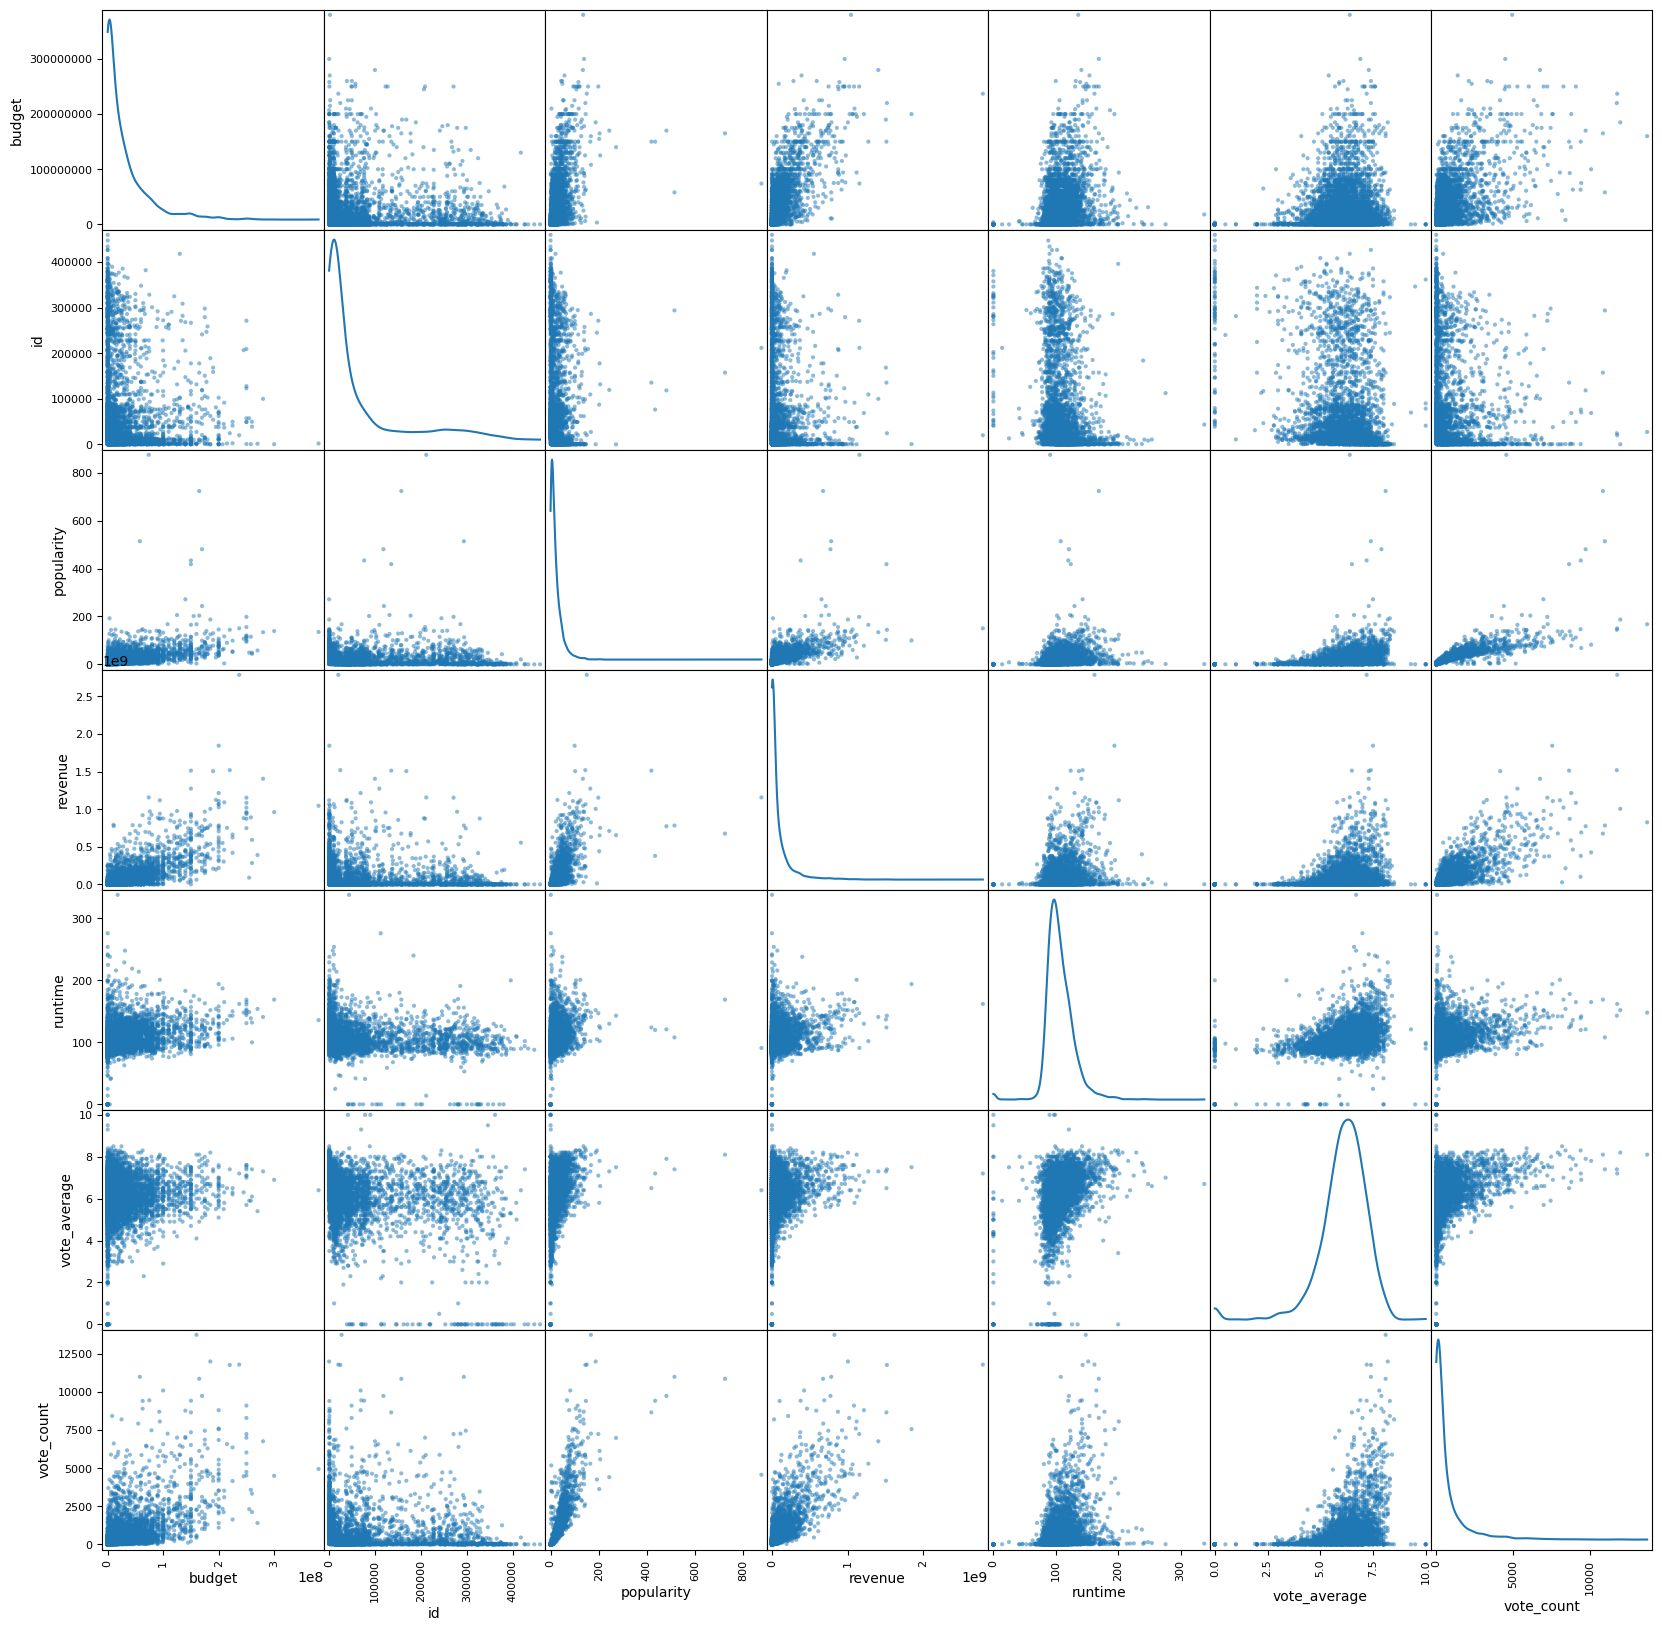

In [ ]:
# Another way to check the correlation between numerical attributes is to use scatter plot.
# Takes a little time to display as it is 7 X 7 matrix
from pandas.plotting import scatter_matrix
pd.plotting.scatter_matrix(movies,figsize = (20,20), diagonal='kde');

# EDAs

WORD CLOUD FOR SOME OF THE FEATURES

In [ ]:
from wordcloud import WordCloud

In [ ]:
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,Spectre,6.3,4466


In [ ]:
# Extract movie titles, remove any null values
titles = credits['title'].dropna()

# Convert titles to a single string
text_titles = " ".join(title for title in titles)

#Extract the genres from string to list
keywords = movies['keywords'].apply(lambda x:' '.join(x))

# Convert to single string
text_keywords = " ".join(keyword for keyword in keywords)

#Extract the genres from string to list
genres = movies['genres'].apply(lambda x:' '.join(x))

# Convert to single string
text_genres = " ".join(genre for genre in genres)

In [ ]:
wordcloud_titles = WordCloud(width=800, height=400, background_color='white').generate(text_titles)
wordcloud_keywords = WordCloud(width=800, height=400, background_color='white').generate(text_keywords)
wordcloud_genres = WordCloud(width=800, height=400, background_color='white').generate(text_genres)

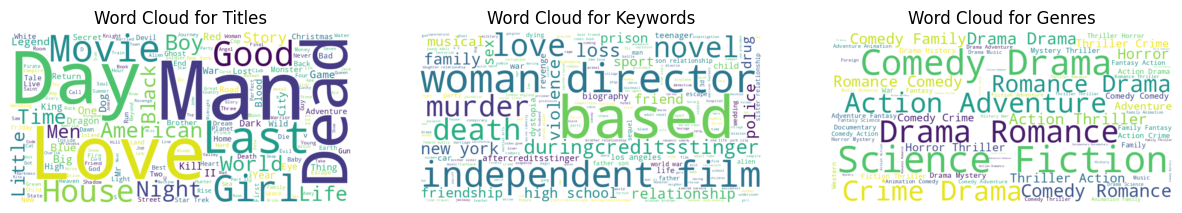

In [ ]:
# Create subplots for the word clouds
plt.figure(figsize=(15, 5))

plt.subplot(131)  # 1 row, 3 columns, 1st subplot
plt.imshow(wordcloud_titles, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Titles')

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
plt.imshow(wordcloud_keywords, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Keywords')

plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
plt.imshow(wordcloud_genres, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Genres')

plt.show()

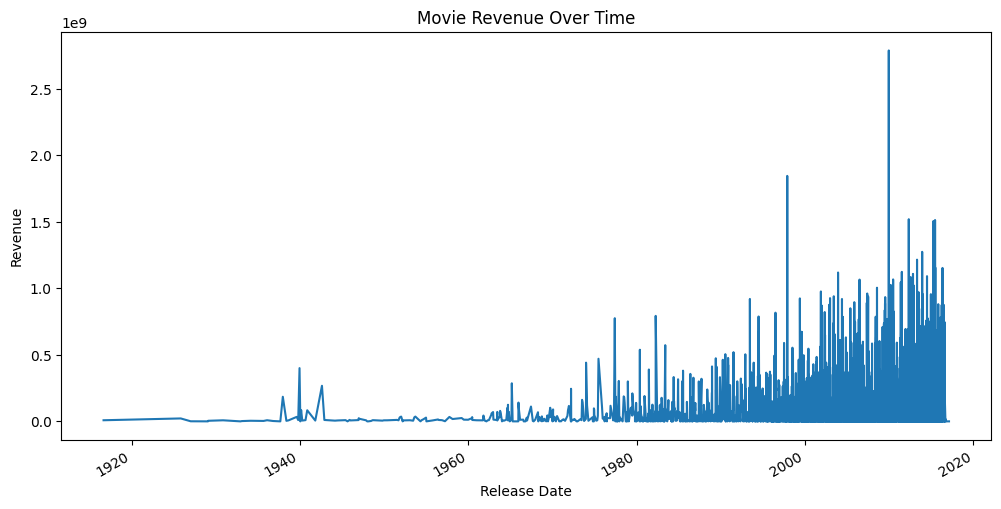

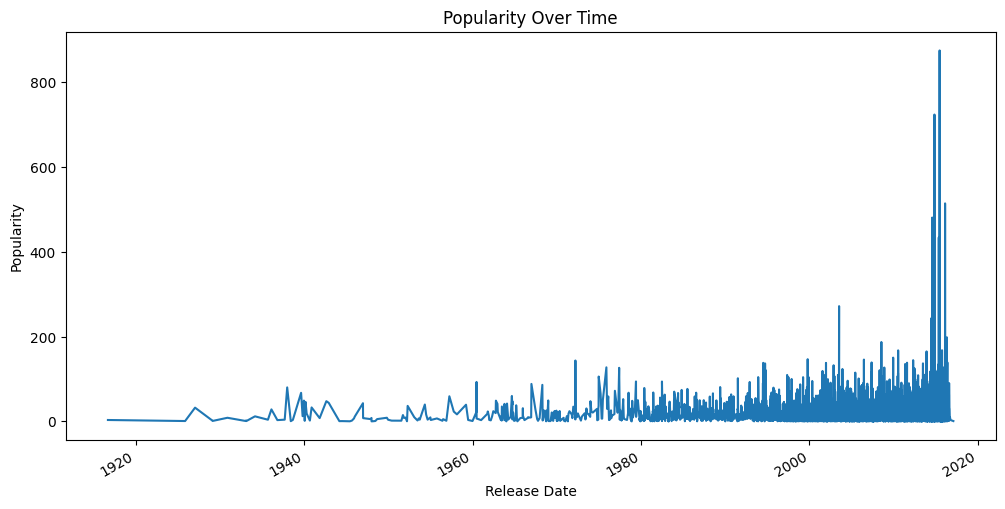

In [ ]:
# Converting 'release_date' column to datetime
movies['release_date'] = pd.to_datetime(movies['release_date'])

# Setting the 'release_date' column as the index
movies.set_index('release_date', inplace=True)

# Creating a time series plot for revenue
plt.figure(figsize=(12, 6))
movies['revenue'].plot(title='Movie Revenue Over Time')
plt.xlabel('Release Date')
plt.ylabel('Revenue')
plt.show()

# Creating a time series plot for popularity
plt.figure(figsize=(12, 6))
movies['popularity'].plot(title='Popularity Over Time')
plt.xlabel('Release Date')
plt.ylabel('Popularity')
plt.show()


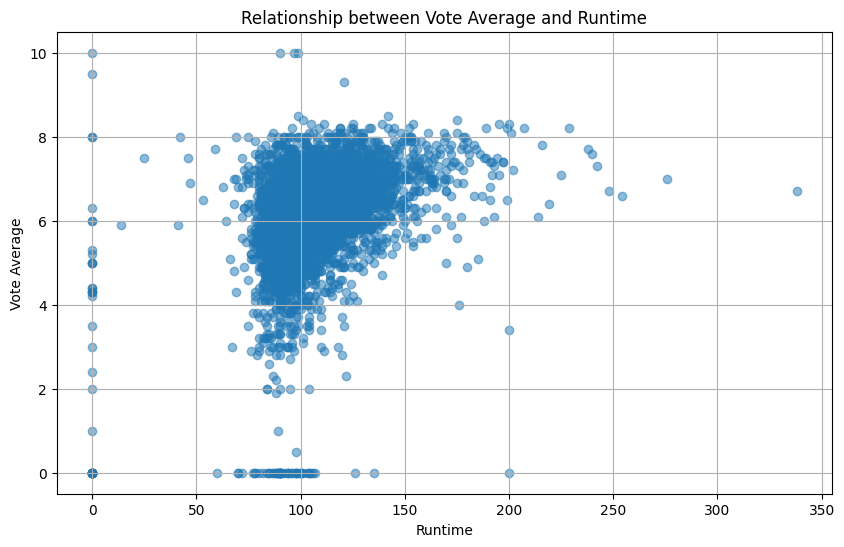

In [ ]:
# Creating a scatter plot for vote_average vs. runtime
plt.figure(figsize=(10, 6))
plt.scatter(movies['runtime'], movies['vote_average'], alpha=0.5)
plt.title('Relationship between Vote Average and Runtime')
plt.xlabel('Runtime')
plt.ylabel('Vote Average')
plt.grid(True)
plt.show()

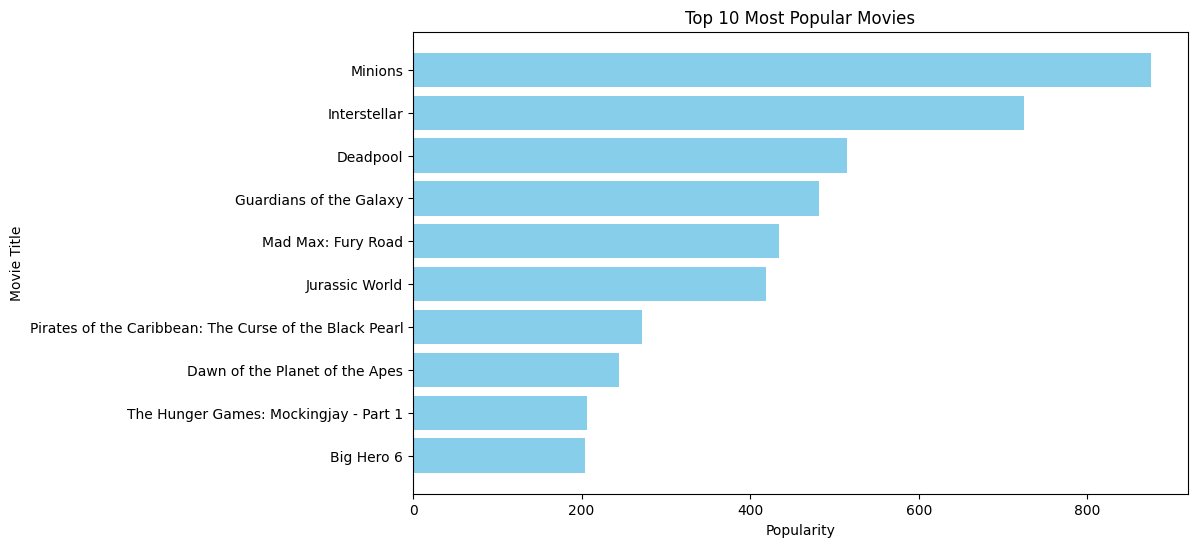

In [ ]:
# Sorting the DataFrame by popularity in descending order and select the top 10
top_10_popular_movies = movies.sort_values(by='popularity', ascending=False).head(10)

# Creating a horizontal bar chart to display the top 10 popular movies
plt.figure(figsize=(10, 6))
plt.barh(top_10_popular_movies['title'], top_10_popular_movies['popularity'], color='skyblue')
plt.xlabel('Popularity')
plt.ylabel('Movie Title')
plt.title('Top 10 Most Popular Movies')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most popular movie at the top
plt.show()

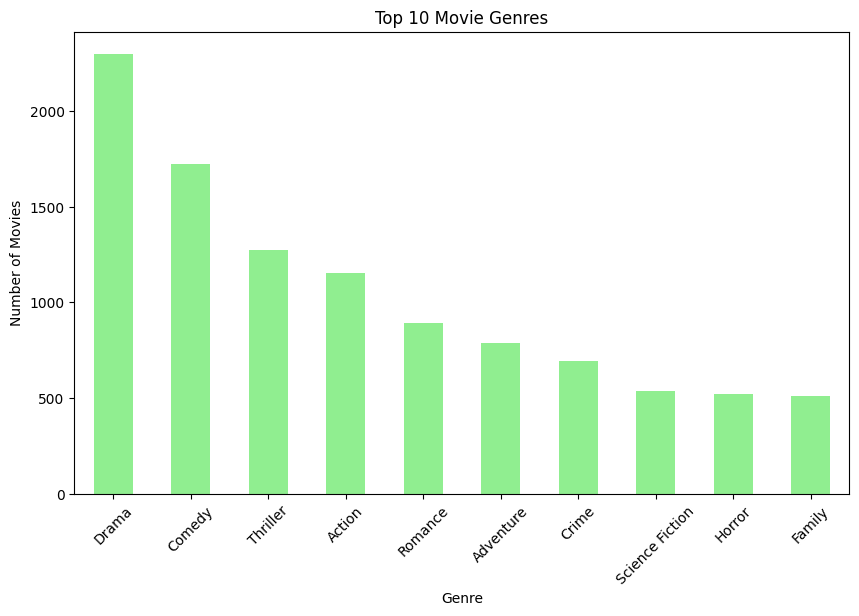

In [ ]:
# Combining all the genre lists into a single list
all_genres = [genre for genre_list in movies['genres'] for genre in genre_list]

# Creating a Series to count the occurrences of each genre
genre_counts = pd.Series(all_genres)

# Getting the top 10 genres
top_10_genres = genre_counts.value_counts().head(10)

# Creating a bar chart to display the top 10 genres
plt.figure(figsize=(10, 6))
top_10_genres.plot(kind='bar', color='lightgreen')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Top 10 Movie Genres')
plt.xticks(rotation=45)
plt.show()


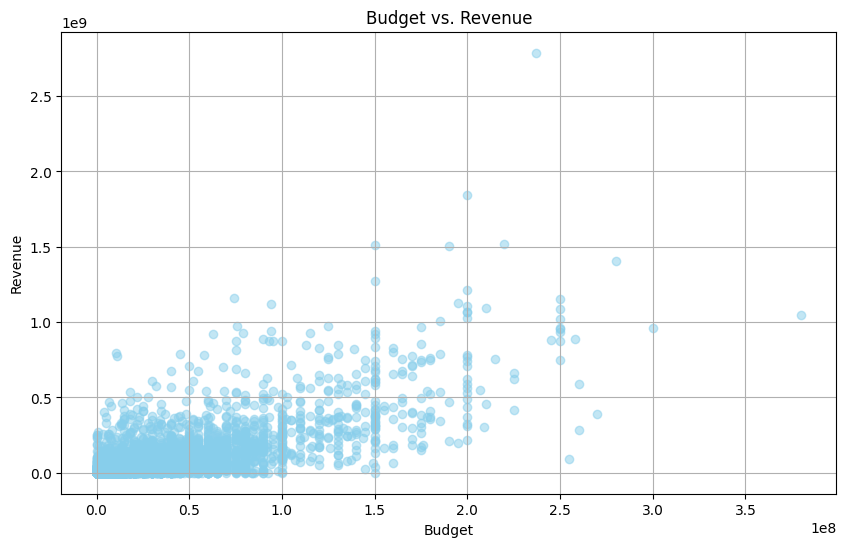

In [ ]:
# Creating a scatter plot for budget vs. revenue
plt.figure(figsize=(10, 6))
plt.scatter(movies['budget'], movies['revenue'], alpha=0.5, color='skyblue')
plt.title('Budget vs. Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()
